In [1]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

import setGPU

I0520 01:23:31.981723 139878913316672 file_utils.py:38] PyTorch version 1.4.0 available.
I0520 01:23:31.983343 139878913316672 file_utils.py:54] TensorFlow version 2.1.0 available.


setGPU: Setting GPU to: 2


In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path=None, num_class=None):
        super(TFGPT2Classifier, self).__init__()
        
        self.dir_path = 'gpt2' if dir_path is None else dir_path
        
        self.gpt2 = TFGPT2Model.from_pretrained(self.dir_path)
        self.num_class = self.gpt2.config.num_labels if num_class is None else num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:] 

        return outputs

In [5]:
TOKENIZER_PATH = './gpt_ckpt/kogpt2_news_wiki_ko_cased_818bfa919d.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token='<unused1>',
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

# KoNLI Simliarity 

In [6]:
tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 128
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
SENT_MAX_LEN = 31
MAX_LEN = (SENT_MAX_LEN * 2) + 6

DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [7]:
# Load Train dataset

TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor.tsv')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
DEV_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.dev.ko.tsv')

train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter = '\t', quoting = 3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
dev_data_xnli = pd.read_csv(DEV_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

train_data_snli_xnli = train_data_snli.append(train_data_xnli)
train_data_snli_xnli = train_data_snli_xnli.dropna()
train_data_snli_xnli = train_data_snli_xnli.reset_index()

dev_data_xnli = dev_data_xnli.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data_snli_xnli), len(dev_data_xnli)))

Total # dataset: train - 942808, dev - 2490


In [9]:
# train_data_snli_xnli = train_data_snli_xnli[:50] # for test

# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
    return sent_clean

train_data_sents = list()

for train_sent_1, train_sent_2 in zip(train_data_snli_xnli['sentence1'], train_data_snli_xnli['sentence2']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(train_sent_1))][:SENT_MAX_LEN] + \
    [vocab[vocab.eos_token], vocab[vocab.sep_token], vocab[vocab.bos_token]] + \
    vocab[tokenizer(clean_text(train_sent_2))][:SENT_MAX_LEN] + [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    
    train_data_sents.append(tokens)
train_data_sents = pad_sequences(train_data_sents, MAX_LEN, value=vocab[vocab.padding_token])

train_data_sents = np.array(train_data_sents, dtype=np.int64)

In [10]:
# dev_data_xnli = dev_data_xnli[:50] # for test

dev_data_sents = list()

for dev_sent_1, dev_sent_2 in zip(dev_data_xnli['sentence1'], dev_data_xnli['sentence2']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(dev_sent_1))][:SENT_MAX_LEN] + \
    [vocab[vocab.eos_token], vocab[vocab.sep_token], vocab[vocab.bos_token]] + \
    vocab[tokenizer(clean_text(dev_sent_2))][:SENT_MAX_LEN] + [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    
    dev_data_sents.append(tokens)

dev_data_sents = pad_sequences(dev_data_sents, MAX_LEN, value=vocab[vocab.padding_token])

dev_data_sents = np.array(dev_data_sents, dtype=np.int64)

In [11]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

train_data_snli_xnli["gold_label_int"] = train_data_snli_xnli["gold_label"].apply(convert_int)
train_data_labels = np.array(train_data_snli_xnli['gold_label_int'], dtype=int)

dev_data_xnli["gold_label_int"] = dev_data_xnli["gold_label"].apply(convert_int)
dev_data_labels = np.array(dev_data_xnli['gold_label_int'], dtype=int)

print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

# train labels: 942808, #dev labels: 2490


In [12]:
sim_model = TFGPT2Classifier('./gpt_ckpt', 3)

I0520 01:25:21.098265 139878913316672 configuration_utils.py:252] loading configuration file ./gpt_ckpt/config.json
I0520 01:25:21.100054 139878913316672 configuration_utils.py:290] Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_beams": 1,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "resid_pdrop": 0.

In [13]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
sim_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [14]:
model_name = "tf2_gpt_kornli"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = sim_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS,
                        validation_data = (dev_data_sents, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

data_out/KOR/tf2_gpt_kornli -- Folder already exists 

Train on 942808 samples, validate on 2490 samples
Epoch 1/3
942720/942808 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.7210
Epoch 00001: val_accuracy improved from -inf to 0.73454, saving model to data_out/KOR/tf2_gpt_kornli/weights.h5
942808/942808 [==============================] - 4402s 5ms/sample - loss: 0.6592 - accuracy: 0.7210 - val_loss: 0.6386 - val_accuracy: 0.7345
Epoch 2/3
942720/942808 [============================>.] - ETA: 0s - loss: 0.5438 - accuracy: 0.7805
Epoch 00002: val_accuracy improved from 0.73454 to 0.75422, saving model to data_out/KOR/tf2_gpt_kornli/weights.h5
942808/942808 [==============================] - 4386s 5ms/sample - loss: 0.5438 - accuracy: 0.7805 - val_loss: 0.6096 - val_accuracy: 0.7542
Epoch 3/3
942720/942808 [============================>.] - ETA: 0s - loss: 0.4968 - accuracy: 0.8028
Epoch 00003: val_accuracy improved from 0.75422 to 0.76104, saving model to data_

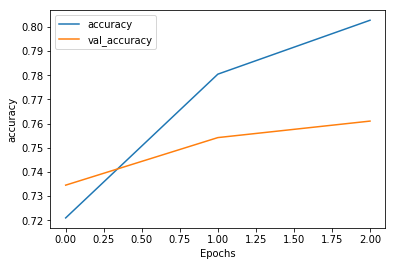

In [22]:
plot_graphs(history, 'accuracy')

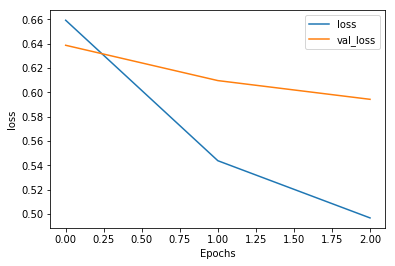

In [21]:
plot_graphs(history, 'loss')

# Quora Simliarity TEST

In [23]:
# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

In [24]:
# test_data_xnli = test_data_xnli[:50] # for test

test_data_sents = list()

for test_sent_1, test_sent_2 in zip(test_data_xnli['sentence1'], test_data_xnli['sentence2']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(test_sent_1))][:SENT_MAX_LEN] + \
    [vocab[vocab.eos_token], vocab[vocab.sep_token], vocab[vocab.bos_token]] + \
    vocab[tokenizer(clean_text(test_sent_2))][:SENT_MAX_LEN] + [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    
    test_data_sents.append(tokens)

test_data_sents = pad_sequences(test_data_sents, MAX_LEN, value=vocab[vocab.padding_token])

test_data_sents = np.array(test_data_sents, dtype=np.int64)

In [25]:
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_data_sents), len(test_data_labels)))

# sents: 5010, # labels: 5010


In [27]:
results = sim_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

5010/5010 [==============================] - 8s 2ms/sample - loss: 0.5751 - accuracy: 0.7631
test loss, test acc:  [0.5751007309216939, 0.76307386]
